In [1]:
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def get_excluded_features():
    df = pd.read_csv('CodeBook-SELECT.csv')
    excluded = []

    for i in range(0, 377):
        desc = df.iloc[i]['Description']
        varname = df.iloc[i]['VarName']

        if 'ISCO' in desc or 'ISCO' in varname:
            excluded.append(varname)

        elif 'ISIC' in desc or 'ISIC' in varname:
            excluded.append(varname)

        elif 'mth' in desc or 'mth' in varname:
            excluded.append(varname)

        elif 'coded' in desc or 'coded' in varname:
            excluded.append(varname)

    return excluded

In [3]:
def get_included_numeric_columns(df):
    # Find numeric columns
    num_col = []
    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.number):
            num_col.append(col)

    print('NUM COL')
    print(len(num_col))

    incl_num_cols = []
    for col in num_col:
        if col != 'job_performance':
            if not df[col].isna().sum() > 10000:
                m = df[col].mean()
                if m >= 1.0:
                    if not (m > 9000.0 and m < 10000.0):
                        incl_num_cols.append(col)

                        if m > 1990.0 and m < 2020.0:
                            df[col] = df[col] - 1990.0

    df[incl_num_cols] = df[incl_num_cols].fillna(df.median().iloc[0])
    
    from sklearn.preprocessing import StandardScaler
    
#     scaler = StandardScaler()
#     scaler.fit(df[incl_num_cols])
#     df[incl_num_cols] = scaler.transform(df[incl_num_cols])
    
    incl_num_cols.append('job_performance')
    
#     incl_num_cols.append('job_performance')
    print('INCL COL')
    print(len(incl_num_cols))

    return df, incl_num_cols

In [4]:
def one_hot_encode(df, col_names):
    print(len(col_names))

    iter = 0
    new_cols = []
    for col in col_names:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            new_cols = new_cols + dummies.columns.tolist()
            df = pd.concat([df,dummies],axis=1)
            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)

            iter = iter + 1
            if (iter % 100 == 0):
                print(iter)

    return df, new_cols

In [5]:
def get_included_cat_cols(df, incl_num_cols):
    # TODO: Remove 999?

    cat_col = list(set(df.columns).difference(set(incl_num_cols)))

    print('CAT COL')
    print(len(cat_col))

    incl_cat_cols = []
    for col in cat_col:
        if 'v' in col and col != 'vet' and len(col) < 5:
            if len(df[col].unique()) < 11:
                incl_cat_cols.append(col)
        else:
            incl_cat_cols.append(col)
    # for col in cat_col:
    #     if len(df[col].unique()) < 11:
    #             incl_cat_cols.append(col)
    #     incl_cat_cols.append(col)
    
    df[incl_cat_cols] = df[incl_cat_cols].fillna(df.mode().iloc[0])

    print('INCL COL')
    print(len(incl_num_cols))

    print('There were {} columns before encoding categorical features'.format(df.shape[1]))
    df, incl_cat_cols = one_hot_encode(df, incl_cat_cols)
    print('There are {} columns after encoding categorical features'.format(df.shape[1]))

    return df, incl_cat_cols

In [6]:
def prepare_train(df, incl_num_cols, incl_cat_cols):
    # Drop 40% of the males to obtain balance
#     sampling_percentage = 0
    sampling_percentage = 40
    dropped_indexes = df[df['gender_r_Male'] == 1].sample(frac=float(sampling_percentage/100)).index

    with open('dropped_indexes_' + str(sampling_percentage) + '.pickle', 'wb') as outfile:
        # dump information to that file
        pickle.dump(dropped_indexes, outfile)

    train_df = df.drop(dropped_indexes)
    print(len(train_df))
    print(len(train_df.columns))
    train_df = train_df[incl_num_cols + incl_cat_cols]

    df = df[incl_num_cols + incl_cat_cols]
    print(len(df))
    print(len(df.columns))

    return df, train_df

In [7]:
def train_and_eval(df, train_df):
    from sklearn.preprocessing import StandardScaler

    X_train = train_df.drop(['job_performance'], axis=1).values
    y_train = train_df['job_performance'].values

#     from sklearn.model_selection import GridSearchCV
#     # Create the parameter grid based on the results of random search
#     param_grid = {
#         'bootstrap': [True],
#         'max_depth': [20],
#         'max_features': ['auto'],
#         'min_samples_leaf': [50],
#         'min_samples_split': [100],
#         'n_estimators': [100]
#     }
#     # Create a based model
#     rf = RandomForestRegressor(random_state = 28)
#     # Instantiate the grid search model
#     grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
#     grid_search.fit(X_train, y_train)

#     print(grid_search.best_params_)
#     clf = grid_search.best_estimator_

    # Train the model using the training sets
#     clf = RandomForestRegressor(max_depth = 10, random_state = 28)
#     print(clf.get_params())
    clf = linear_model.LinearRegression()
    clf.fit(X_train, y_train)

    X_train = df.drop(['job_performance'], axis=1).values
    y_train = df['job_performance'].values

    y_pred = clf.predict(X_train)
    
    print(y_train[0:50])
    print(y_pred[0:50])

    print('Mean: ' + str(np.mean(y_pred)))
    print('Variance: ' + str(np.var(y_pred)))

#     return clf, mean_squared_error(y_train, y_pred), grid_search
    return clf, mean_squared_error(y_train, y_pred)

In [8]:
def main_1(model_name):
    df = pd.read_csv('hw4-trainingset-gd2551.csv')
    df = df.drop(['uni', 'row'] + get_excluded_features(), axis=1)

    # Impute columns simply with mode
#     df = df.fillna(df.mode().iloc[0])

    df, incl_num_cols = get_included_numeric_columns(df)

    df, incl_cat_cols = get_included_cat_cols(df, incl_num_cols)

    df, train_df = prepare_train(df, incl_num_cols, incl_cat_cols)

    clf, mse = train_and_eval(df, train_df)

    print('MSE: ' + str(mse))

    with open(model_name, 'wb') as outfile:
        pickle.dump(clf, outfile)

    return df

In [9]:
def main_2(model_name, train_cols):
    df = pd.read_csv('hw4-testset-gd2551.csv')
    df = df.drop(['uni', 'row'] + get_excluded_features(), axis=1)

    # Impute columns simply with mode
#     df = df.fillna(df.mode().iloc[0])

    df, incl_num_cols = get_included_numeric_columns(df)

    df, incl_cat_cols = get_included_cat_cols(df, incl_num_cols)

    for missing_col in list(set(train_cols).difference(set(df.columns))):
        df[missing_col] = np.zeros(24500, dtype='int')

    df = df[train_cols]

    X_test = df.drop(['job_performance'], axis=1).values

    with open(model_name, 'rb') as infile:
        clf = pickle.load(infile)

    df['job_performance'] = clf.predict(X_test)

    print('Mean: ' + str(np.mean(df['job_performance'])))
    print('Variance: ' + str(np.var(df['job_performance'])))

    return df

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3209: DtypeWarning: Columns (50,172,255,256,257,258,268,280,376) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


NUM COL
60


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1019: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:908: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


INCL COL
24
CAT COL
319
INCL COL
24
There were 343 columns before encoding categorical features
277
100
200
There are 1249 columns after encoding categorical features
15002
1249
20000
1196
[2496.02548403 3072.47145243 3286.83878409 3067.76092539 2394.30356909
 2072.3991696  2152.94455608 2068.94502318 3259.1151392  3120.18034233
 2493.98384909 3109.46200381 3053.03022118 2956.77717358 3658.16696551
 2935.80909541 2834.80535639 3119.71626899 3364.41576159 2508.18552499
 2602.67891006 2949.11465928 2629.17162165 2311.45184957 2326.75999289
 3522.99818668 2839.8322706  2465.01652794 3204.33544519 3579.1731816
 3146.91104736 3537.41230166 2819.64554164 3286.95650015 2910.77229059
 2783.83377339 2553.4168157  2870.3835322  3337.26716195 3058.91670701
 2387.15427156 2195.91236657 2084.02341886 2860.34112407 2656.80055992
 3372.9523918  3245.44120661 3097.67140141 2630.98194259 3233.08466627]
[2661.68587344 2783.59950413 3440.30727645 2892.08700395 2877.52352137
 2236.02344154 2727.09861925 2

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e753278>]],
      dtype=object)

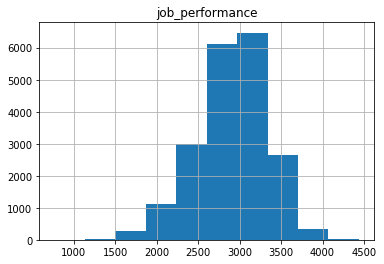

In [10]:
x = main_1('test_model.pickle')
# print('NUMS')
#     print(set(x).difference(set(a)))
# print('----')
# print(set(a).difference(set(x)))
# print('----')
#
# print('CATS')
# print(set(y).difference(set(b)))
# print('----')
# print(set(b).difference(set(y)))
# print('----')

%matplotlib inline
x.hist(column='job_performance')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b35b940>]],
      dtype=object)

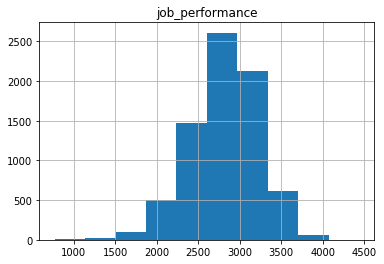

In [11]:
x[x['gender_r_Male'] == 0].hist(column='job_performance')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b5c0ac8>]],
      dtype=object)

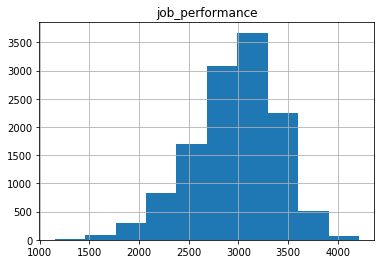

In [12]:
x[x['gender_r_Male'] == 1].hist(column='job_performance')

In [13]:
%matplotlib inline
a = main_2('test_model.pickle', x.columns)
a.hist(column='job_performance')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3209: DtypeWarning: Columns (50,172,255,256,257,258,260,268) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


NUM COL
60


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1019: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:908: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


INCL COL
16
CAT COL
327
INCL COL
16
There were 343 columns before encoding categorical features
280
100
200
There are 1256 columns after encoding categorical features


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
a[a['gender_r_Male'] == 0].hist(column='job_performance')

In [ ]:
a[a['gender_r_Male'] == 1].hist(column='job_performance')